# Tutorial
Learn how to use the Mira-Titan Universe HMF emulator.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import MiraTitanUniverseHMFemulator

print("Version", MiraTitanUniverseHMFemulator.__version__)

Version 0.0.0


## Initialize the emulator
This may take a few seconds: the code pre-computes a bunch of matrix inversions (through Cholesky decomposition).

In [2]:
HMFemu = MiraTitanUniverseHMFemulator.Emulator()

## Input cosmology
Let's define a set of cosmology parameter for which we want the HMF. In case you are unsure about the parameters and their ranges, you can grab that from the emulator instance we just created. Don't worry, the emulator will complain (with a useful error message) if it doesn't like your input cosmology.

In [3]:
HMFemu.param_limits

{'Ommh2': (0.12, 0.155),
 'Ombh2': (0.0215, 0.0235),
 'Omnuh2': (0, 0.01),
 'n_s': (0.85, 1.05),
 'h': (0.55, 0.85),
 'sigma_8': (0.7, 0.9),
 'w_0': (-1.3, -0.7),
 'w_a': (-1.73, 1.28),
 'w_b': (0.3, 1.3)}

### Note about dark energy equation-of-state parametrization
The emulator itself works in the space of $(w_0, w_b)$, where $w_b = (-w_0 -w_a)^{1/4}$ (see paper). The user is expected to provide the parameters in the usual space of $(w_0, w_a)$ and the code will handle the conversion for you!

In [4]:
fiducial_cosmo = {'Ommh2': .3*.7**2,
                  'Ombh2': .022,
                  'Omnuh2': .006,
                  'n_s': .96,
                  'h': .7,
                  'w_0': -1,
                  'w_a': 0,
                  'sigma_8': .8,
                 }

## Call the emulator
It's as easy as:

In [5]:
res = HMFemu.predict(fiducial_cosmo)

Now let's look at the output stored in the `res` dictionary. Each (numerical) key corresponds to a redshift for which the emulator computed the HMF. There's a `Units` key, too.

In [6]:
print(res.keys())

dict_keys(['Units', 2.02, 1.61, 1.01, 0.656, 0.434, 0.242, 0.101, 0.0])


In [7]:
print(res['Units'])

log10_M is log10(Mass in [Msun/h]), HMFs are given in [h^2 Msun/Mpc^3]


So far, nothing too dramatic. Now let's look into one of the redshift outputs:

In [8]:
print("Keys of res[0.0]:\t", res[0.0].keys())
print("Redshift of res[0.0]:\t", res[0.0]['redshift'])
print("Array of (log) masses:\t", res[0.0]['log10_M'])
print("The emulated HMF\t", res[0.0]['HMF'])

Keys of res[0.0]:	 dict_keys(['redshift', 'log10_M', 'HMF', 'wstar', 'wstar_covmat', 'PC_weight'])
Redshift of res[0.0]:	 0.0
Array of (log) masses:	 [13.      13.00075 13.0015  ... 15.09775 15.0985  15.09925]
The emulated HMF	 [3.34203450e-04 3.33450191e-04 3.32698490e-04 ... 2.13904071e-12
 2.08848447e-12 2.03904633e-12]


This cries for a nice plot. Note that the emulator covers the HMF down to about 1e-12, which corresponds to different masses at different redshifts.

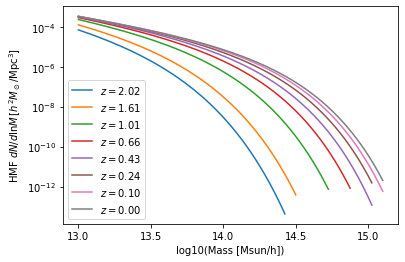

In [9]:
for z in HMFemu.z_arr:
    plt.semilogy(res[z]['log10_M'], res[z]['HMF'], label='$z=%.2f$'%z)
plt.xlabel('log10(Mass [Msun/h])')
plt.ylabel('HMF $dN/d\lnM\,[h^2 M_\odot/\\mathrm{Mpc}^3]$')
plt.legend()

OK, now we understand the basic concept. Let's try another cosmology with for dark energy just for fun.

In [10]:
DE_cosmo = {'Ommh2': .3*.7**2,
            'Ombh2': .022,
            'Omnuh2': .006,
            'n_s': .96,
            'h': .6,
            'w_0': -1.3,
            'w_a': -1,
            'sigma_8': .8,
           }

In [11]:
res_DE = HMFemu.predict(DE_cosmo)

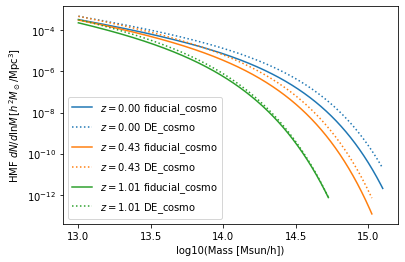

In [12]:
colors=['C%s'%i for i in range(3)]
for i,z in enumerate([0.0, 0.434, 1.01]):
    plt.semilogy(res[z]['log10_M'], res[z]['HMF'], color=colors[i], label='$z=%.2f$ fiducial_cosmo'%z)
    plt.semilogy(res[z]['log10_M'], res_DE[z]['HMF'], color=colors[i], label='$z=%.2f$ DE_cosmo'%z, ls=':')
plt.xlabel('log10(Mass [Msun/h])')
plt.ylabel('HMF $dN/d\lnM\,[h^2 M_\odot/\\mathrm{Mpc}^3]$')
plt.legend()

## Emulator uncertainty
Under construction...